In [1]:
!pip install datasets
#!pip install optuna
!pip install scikit-multilearn
!pip install PyEvALL
! pip install --quiet timm

import pandas as pd
import logging
from datasets import Dataset
import os
#import optuna

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import BertTokenizer, BertModel
from sklearn.metrics import f1_score
from tqdm import tqdm
from PIL import Image
import timm

# Import the drive library
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('drive/MyDrive/Colab/thesis/models')
from utils_classification import *

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [3]:
# Define the multimodal dataset class
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, dir, data_dir, bin_label, tokenizer, max_length, transform=None):
        self.dataframe = dataframe
        self.dir = dir
        self.data_dir = data_dir
        self.bin_label = bin_label
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        #if idx is a batch of indices (which is a list or tensor), process each index
        if isinstance(idx, (list, torch.Tensor)):
            rows = self.dataframe.iloc[idx]  #this returns a df (batch of rows)
        else:
            rows = self.dataframe.iloc[[idx]]  #single index (returns a df with 1 row)

        #initialize lists for processed data
        img_paths = []
        texts = []
        labels = []

        #process each row in the batch
        for _, row in rows.iterrows():  #use iterrows() to access each row in the batch
            img_name = str(row['meme path'])
            img_path = os.path.join(f"{self.dir}/datasets/{self.data_dir}/", img_name)
            text = str(row['meme text'])
            label = row[self.bin_label]

            #append to the lists
            img_paths.append(img_path)
            texts.append(text)
            labels.append(label)

        #process images in the batch
        images = [Image.open(img_path).convert('RGB') for img_path in img_paths]
        if self.transform:
            images = [self.transform(image) for image in images]

        #process text using the tokenizer
        encodings = [self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        ) for text in texts]

        #stack the encoding results
        input_ids = torch.stack([encoding["input_ids"].flatten() for encoding in encodings])
        attention_mask = torch.stack([encoding["attention_mask"].flatten() for encoding in encodings])

        #convert labels to tensor
        labels = torch.tensor(labels, dtype=torch.long)

        return {
            "image": torch.stack(images),
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }


# Define the multimodal model
class MultimodalClassifier(nn.Module):
    def __init__(self, bert_model, num_classes, fusion_output_size=512):
        super(MultimodalClassifier, self).__init__()
        self.bert = bert_model
        self.swin = timm.create_model('swinv2_base_window8_256', pretrained=True, num_classes=0)

        self.text_projection = nn.Linear(self.bert.config.hidden_size, fusion_output_size)
        self.image_projection = nn.Linear(self.swin.num_features, fusion_output_size)

        self.fusion_layers = nn.Sequential(
            nn.LayerNorm(fusion_output_size * 2),
            nn.Linear(fusion_output_size * 2, fusion_output_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(fusion_output_size),
            nn.Linear(fusion_output_size, fusion_output_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.LayerNorm(fusion_output_size)
        )

        self.classifier = nn.Linear(fusion_output_size, num_classes)

    def forward(self, input_ids, attention_mask, image):
        text_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)[1]
        image_outputs = self.swin(image)

        text_projected = self.text_projection(text_outputs)
        image_projected = self.image_projection(image_outputs)

        combined = torch.cat((text_projected, image_projected), dim=1)
        fused = self.fusion_layers(combined)
        outputs = self.classifier(fused)
        return outputs

In [4]:
# Set up training and evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
max_length = 512
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 1e-5

# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
dir = "/content/drive/MyDrive/Colab/thesis"

# EXIST

## Binary Classification: Sexist vs. non-sexist

In [6]:
ds_name = "EXIST2024"
evaluation_type = "binary"
# Load datasets
exist_training_data = "".join([dir, "/data/EXIST2024/EXIST2024_training.json"])
exist_val_data = "".join([dir,"/data/EXIST2024/EXIST2024_validation.json"])
exist_test_data = "".join([dir, "/data/EXIST2024/EXIST2024_test.json"])
exist_train_df = pd.read_json(exist_training_data,orient='index')
exist_dev_df = pd.read_json(exist_val_data,orient='index')
exist_test_df = pd.read_json(exist_test_data,orient='index')

# Create datasets
data_dir = "EXIST 2024"
binary_label = "sexist"
train_dataset = MultimodalDataset(exist_train_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
val_dataset = MultimodalDataset(exist_dev_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)
test_dataset = MultimodalDataset(exist_test_df, dir, data_dir, binary_label, tokenizer, max_length, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [8]:
# Create the model
bert_model = BertModel.from_pretrained("bert-base-uncased")
model = MultimodalClassifier(bert_model, num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
# Train and validate the model
best_val_f1 = 0
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validate the model
    model.eval()
    val_preds = []
    val_true = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            labels = batch["labels"].to(device)
            outputs = model(input_ids, attention_mask, images)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    val_f1 = f1_score(val_true, val_preds, average='macro')
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val F1: {val_f1:.4f}")

    # Save the best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        save_path = f"{dir}/models/in_domain/{ds_name}/{evaluation_type}/multimodal"
        os.makedirs(save_path, exist_ok=True)
        torch.save(model.state_dict(), f"{save_path}/best_multimodal_model_sexism.pth")

Epoch 1/10: 100%|██████████| 87/87 [07:35<00:00,  5.24s/it]


Epoch [1/10], Train Loss: 0.7070, Val F1: 0.6074


Epoch 2/10: 100%|██████████| 87/87 [01:07<00:00,  1.30it/s]


Epoch [2/10], Train Loss: 0.5497, Val F1: 0.7041


Epoch 3/10: 100%|██████████| 87/87 [01:08<00:00,  1.27it/s]


Epoch [3/10], Train Loss: 0.3955, Val F1: 0.4421


Epoch 4/10: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]


Epoch [4/10], Train Loss: 0.2649, Val F1: 0.6797


Epoch 5/10: 100%|██████████| 87/87 [01:06<00:00,  1.32it/s]


Epoch [5/10], Train Loss: 0.1572, Val F1: 0.7202


Epoch 6/10: 100%|██████████| 87/87 [01:07<00:00,  1.29it/s]


Epoch [6/10], Train Loss: 0.0935, Val F1: 0.7130


Epoch 7/10: 100%|██████████| 87/87 [01:05<00:00,  1.32it/s]


Epoch [7/10], Train Loss: 0.0425, Val F1: 0.7121


Epoch 8/10: 100%|██████████| 87/87 [01:06<00:00,  1.32it/s]


Epoch [8/10], Train Loss: 0.0414, Val F1: 0.6668


Epoch 9/10: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]


Epoch [9/10], Train Loss: 0.0169, Val F1: 0.7018


Epoch 10/10: 100%|██████████| 87/87 [01:06<00:00,  1.31it/s]


Epoch [10/10], Train Loss: 0.0112, Val F1: 0.6902


In [ ]:
# Load the best model and evaluate on the test set
model.load_state_dict(torch.load(f"{dir}/models/in_domain/{ds_name}/{evaluation_type}/multimodal/best_multimodal_model_sexism.pth"))
model.eval()
y_pred = []
y_test = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        images = batch["image"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids, attention_mask, images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_test.extend(labels.cpu().numpy())

Testing: 100%|██████████| 11/11 [00:50<00:00,  4.60s/it]


Saved EXIST2024 test split binary evaluation to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/multimodal_bert_swin_EXIST2024_test_binary.json
Saved EXIST2024 test split to /content/drive/MyDrive/Colab/thesis/models/evaluation/predictions/EXIST2024/multimodal_bert_swin_EXIST2024_test_answer.txt
----------------------------------------------------------------------------------------------------
Classification Report for Multimodal (BERT + Swin):
              precision    recall  f1-score   support

  non-sexist       0.64      0.62      0.63        76
      sexist       0.70      0.73      0.72        95

    accuracy                           0.68       171
   macro avg       0.67      0.67      0.67       171
weighted avg       0.68      0.68      0.68       171

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------

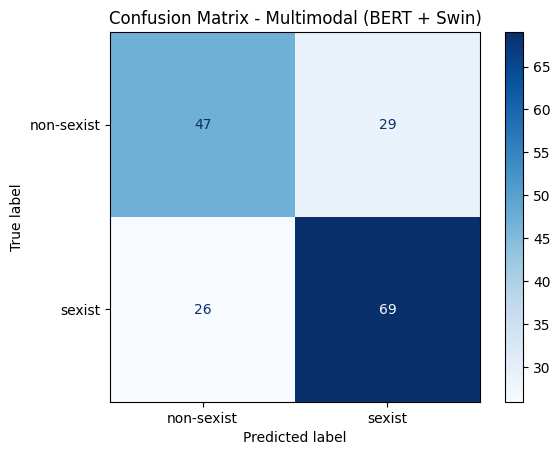

----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
PyEvaLL Metrics for Multimodal (BERT + Swin):

2025-04-10 21:38:05,607 - pyevall.evaluation - INFO -             evaluate() - Evaluating the following metrics ['ICM', 'ICMNorm', 'FMeasure']
2025-04-10 21:38:05,879 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-10 21:38:05,936 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM Normalized evaluation method
2025-04-10 21:38:05,938 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-10 21:38:06,002 - pyevall.metrics.metrics - INFO -             evaluate() - Executing ICM evaluation method
2025-04-10 21:38:06,078 - pyevall.metrics.metrics - INFO -             evaluate() - Executing fmeasure evaluation method
This is a ta

In [ ]:
gold_path_test_binary =  dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_{evaluation_type}.json"
gold_test_txt = dir+f"/models/evaluation/golds/{ds_name}/{ds_name}_test_truth.txt"
#create file with predictions
test_pred_json,test_pred_txt = save_evaluation(exist_test_df, dir+"/models/evaluation/predictions", ds_name, "test", evaluation_type, "multimodal_bert_swin", y_pred , binary_label, [])
#get evaluation metrics
evaluate_binary_classification(gold_path_test_binary,test_pred_json,
                               y_test,y_pred,
                                ["non-sexist","sexist"],
                               gold_test_txt,test_pred_txt,
                               model_name="Multimodal (BERT + Swin)")

In [ ]:
#save predictions on test set
output_dir = os.path.join(dir, "models","output",ds_name) #creating dir for output
os.makedirs(output_dir, exist_ok=True)
output_path = f"{output_dir}/multimodal_bert_swin_{ds_name}_test_{evaluation_type}.csv"
save_predictions_csv(exist_test_df, y_pred, [binary_label], output_path)